# Part A: Model Code


In [1]:
import numpy as np
from itertools import combinations, chain
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import sys
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = np.array([[2,2], [5,4]])

def get_all_combinations(features, degree): 
    feature = np.arange(0, features)
    final = chain.from_iterable(itertools.product(feature,repeat = i) for i in range(1, degree+1))
    new_array = [tuple(sorted(row)) for row in final]
    return set(new_array)
    

def polynomialFeatures(X, degree):
    n_samples, n_features = X.shape
    tmp = get_all_combinations(n_features, degree)
    total_features = len(list(tmp))
   
    XP = np.empty((n_samples, total_features), dtype=X.dtype)
    for i, comb in enumerate(tmp):
        XP[:, i] = X[:, comb].prod(1)
    return XP

print(polynomialFeatures(data,2))

[[ 4  4  2  2  4]
 [20 25  5  4 16]]


In [2]:
def mse(Y_true, Y_pred):
    
    error = abs((np.square(Y_true - Y_pred)).mean())
    error = np.round(error, 4) 
    return error 

mse(np.array([3.3,4.8]),np.array([4.9,4.89898]))

1.2849

In [3]:
def learning_curve(model, X, Y, cv, train_size=10, learning_rate=0.01,
                  epochs=1000, tol=None, regularizer=None, lambd=0.0, **kwargs):
    
    no_of_iterations = np.ceil(X.shape[0]/ train_size)
    train_rmse = []
    test_rmse =[]
    train_size_list =[]
  
    for i in range(int(no_of_iterations)):
        train_size_list.append((i+1)*train_size)
        X_new = X[: (i+1)*train_size,:] 
        y_new = Y[: (i+1)*train_size]
            
        model = Linear_Regression()
        outputs = kFold(cv, X_new, y_new, model, "rmse", learning_rate=0.01,
                  epochs=1000, tol=None, regularizer=None, lambd=0.0)
                
        train_error, test_error = outputs[2], outputs[3]
        
        train_rmse.append(train_error)
        test_rmse. append(test_error)
    
    return train_rmse, test_rmse, train_size_list
        
    
    

In [4]:
def plot_polynomial_model_complexity(model, X, Y, cv, maxPolynomialDegree, learning_rate=0.01,
                                 epochs=1000, tol=None, regularizer=None, lambd=0.0, **kwargs):
    train_error_list, test_error_list = [], []  
    degree_list = np.arange(1, maxPolynomialDegree+1)
    for i in range(1,maxPolynomialDegree+1):
        
        X_poly = polynomialFeatures(X, i)
        model = Linear_Regression()
        train_rmse, test_rmse, train_size = learning_curve(model, X_poly, Y, cv, train_size=50, learning_rate=0.01,
                  epochs=1000, tol=None, regularizer=None, lambd=0.0, **kwargs)
        
        
        train_error_list.append(np.mean(train_rmse))
        test_error_list.append(np.mean(test_rmse))
        
        plt.figure(figsize=(10, 6))
        plt.plot(train_size, train_rmse, "r-+", linewidth=3, label="Training Score")
        plt.plot(train_size, test_rmse, "b-", linewidth=2, label="Cross-validation Score")
        plt.legend(loc="best", fontsize=14) 
        plt.xlabel("Training set size", fontsize=14) 
        plt.ylabel("RMSE", fontsize=14) 
        plt.title("Learning Curve for degree "+str(i))
        plt.show()
        
        
        
        

    
    plt.figure(figsize=(10, 6))
    plt.plot(degree_list, train_error_list, "r-+", linewidth=3, label="Training Score")
    plt.plot(degree_list, test_error_list, "b-", linewidth=2, label="Cross-validation Score")
    plt.legend(loc="best", fontsize=14) 
    plt.xlabel("Degree", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14) 
    plt.title("Learning Curve for all degrees ")
    plt.show()
        

In [5]:
def regularizer_error(l, y_pred, y, theta, error_function):
        
    if y_pred.shape==y.shape:
        
        if error_function == "rmse":
            error = np.sqrt(abs(mse(y_pred,y)))
            
        else:
            error = abs(mse(y_pred,y))

            
        theta = theta[1:]

            
            
        if l =="l2":
            return error, np.round(np.sum(np.square(theta)), 4)
        
        elif l == "l1":
            return error, np.sum(theta)
        
        elif l == None:
            return error , None
        return None
        
    else:
        print('Both vectors are unequal')
        return None


In [6]:
class Linear_Regression:
    def __init__(self):
        pass
    
    def fit(self, X, y, learning_rate=0.01, epochs=1000, tol=None, regularizer=None,lambd=0.0,**kwargs):
        self.degree = None
        for key, value in kwargs.items():
            if key == "degree":
                self.degree = value
                
            if key == "error":
                self.error_function = value
        
        
        self.X = X
        self.y = y
        self.learning_rate =learning_rate
        self.epochs = epochs
        self.tol = tol
        self.regularizer =regularizer
        self.lambd = lambd
        
        theta_hat = np.zeros(shape = (self.X.shape[1]+1,))
               
        m = self.X.shape[0]
        X_bias=np.c_[np.ones((self.X.shape[0],1)),self.X]
        y_hat = np.dot(X_bias, theta_hat)
        prev_theta_hat = theta_hat # to save a copy of the previous theta values
        prev_error, regularized_theta = regularizer_error(self.regularizer, y_hat,self.y , theta_hat, self.error_function)

       
        for epoch in range(self.epochs):           
            
            if regularizer == "l1":             
                regularized_constant = (self.learning_rate*self.lambd*(-1 if regularized_theta < 0 else 1)/ m)   
                               
            elif regularizer == "l2": 
                regularized_constant = (self.learning_rate*self.lambd* regularized_theta)/ m
                
            else:
                regularized_constant = 0
           
            
            theta_hat = theta_hat - ((self.learning_rate/m)*np.dot(X_bias.T , (y_hat - self.y))) - regularized_constant 
            theta_hat = np.round(theta_hat, 4)
            y_hat = np.dot(X_bias, theta_hat)
            y_hat = np.round(y_hat, 4) 
            current_error, regularized_theta = regularizer_error(self.regularizer, y_hat, self.y, theta_hat, self.error_function )
            
            if tol:
                if current_error - tol > prev_error:
                    theta_hat = prev_theta_hat
                    # if current error is greater save prev theta_hat                        
                    break
        
            prev_theta_hat = theta_hat  # save copy to compute contigous errors.
            prev_error = current_error                            
        self.theta = theta_hat                        
        
        
        
    def predict(self, X_test):
        X_test_bias=np.c_[np.ones((X_test.shape[0],1)),X_test]
        y_pred = np.dot(X_test_bias, self.theta)
        return y_pred
    
    def polyPredict(self, X_test, degree):
        X_test_bias=np.c_[np.ones((X_test.shape[0],1)),X_test]
        X_test_bias = polynomialFeatures(X_test_bias, self.degree)
        y_pred = np.dot(X_test_bias, self.theta)
        
        return y_pred
        

# Part B: Data Processing

In [7]:
df = pd.read_csv('winequality-red.csv')
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


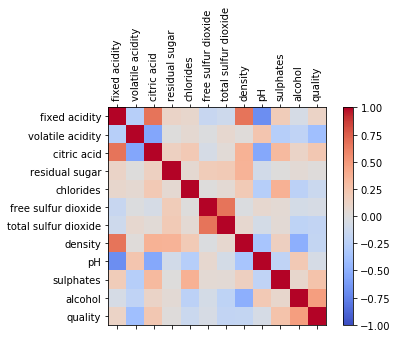

In [8]:
corr = df.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.columns)
plt.show()

In [9]:
df.sample(frac=1) 

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1442,6.9,0.630,0.02,1.9,0.078,18.0,30.0,0.99712,3.40,0.75,9.80,5
128,8.0,0.590,0.16,1.8,0.065,3.0,16.0,0.99620,3.42,0.92,10.50,7
76,8.8,0.410,0.64,2.2,0.093,9.0,42.0,0.99860,3.54,0.66,10.50,5
800,7.2,0.610,0.08,4.0,0.082,26.0,108.0,0.99641,3.25,0.51,9.40,5
1495,7.0,0.430,0.02,1.9,0.080,15.0,28.0,0.99492,3.35,0.81,10.60,6
644,9.9,0.540,0.45,2.3,0.071,16.0,40.0,0.99910,3.39,0.62,9.40,5
450,11.9,0.390,0.69,2.8,0.095,17.0,35.0,0.99940,3.10,0.61,10.80,6
860,7.2,0.620,0.06,2.7,0.077,15.0,85.0,0.99746,3.51,0.54,9.50,5
637,9.5,0.885,0.27,2.3,0.084,31.0,145.0,0.99780,3.24,0.53,9.40,5
267,7.9,0.350,0.46,3.6,0.078,15.0,37.0,0.99730,3.35,0.86,12.80,8


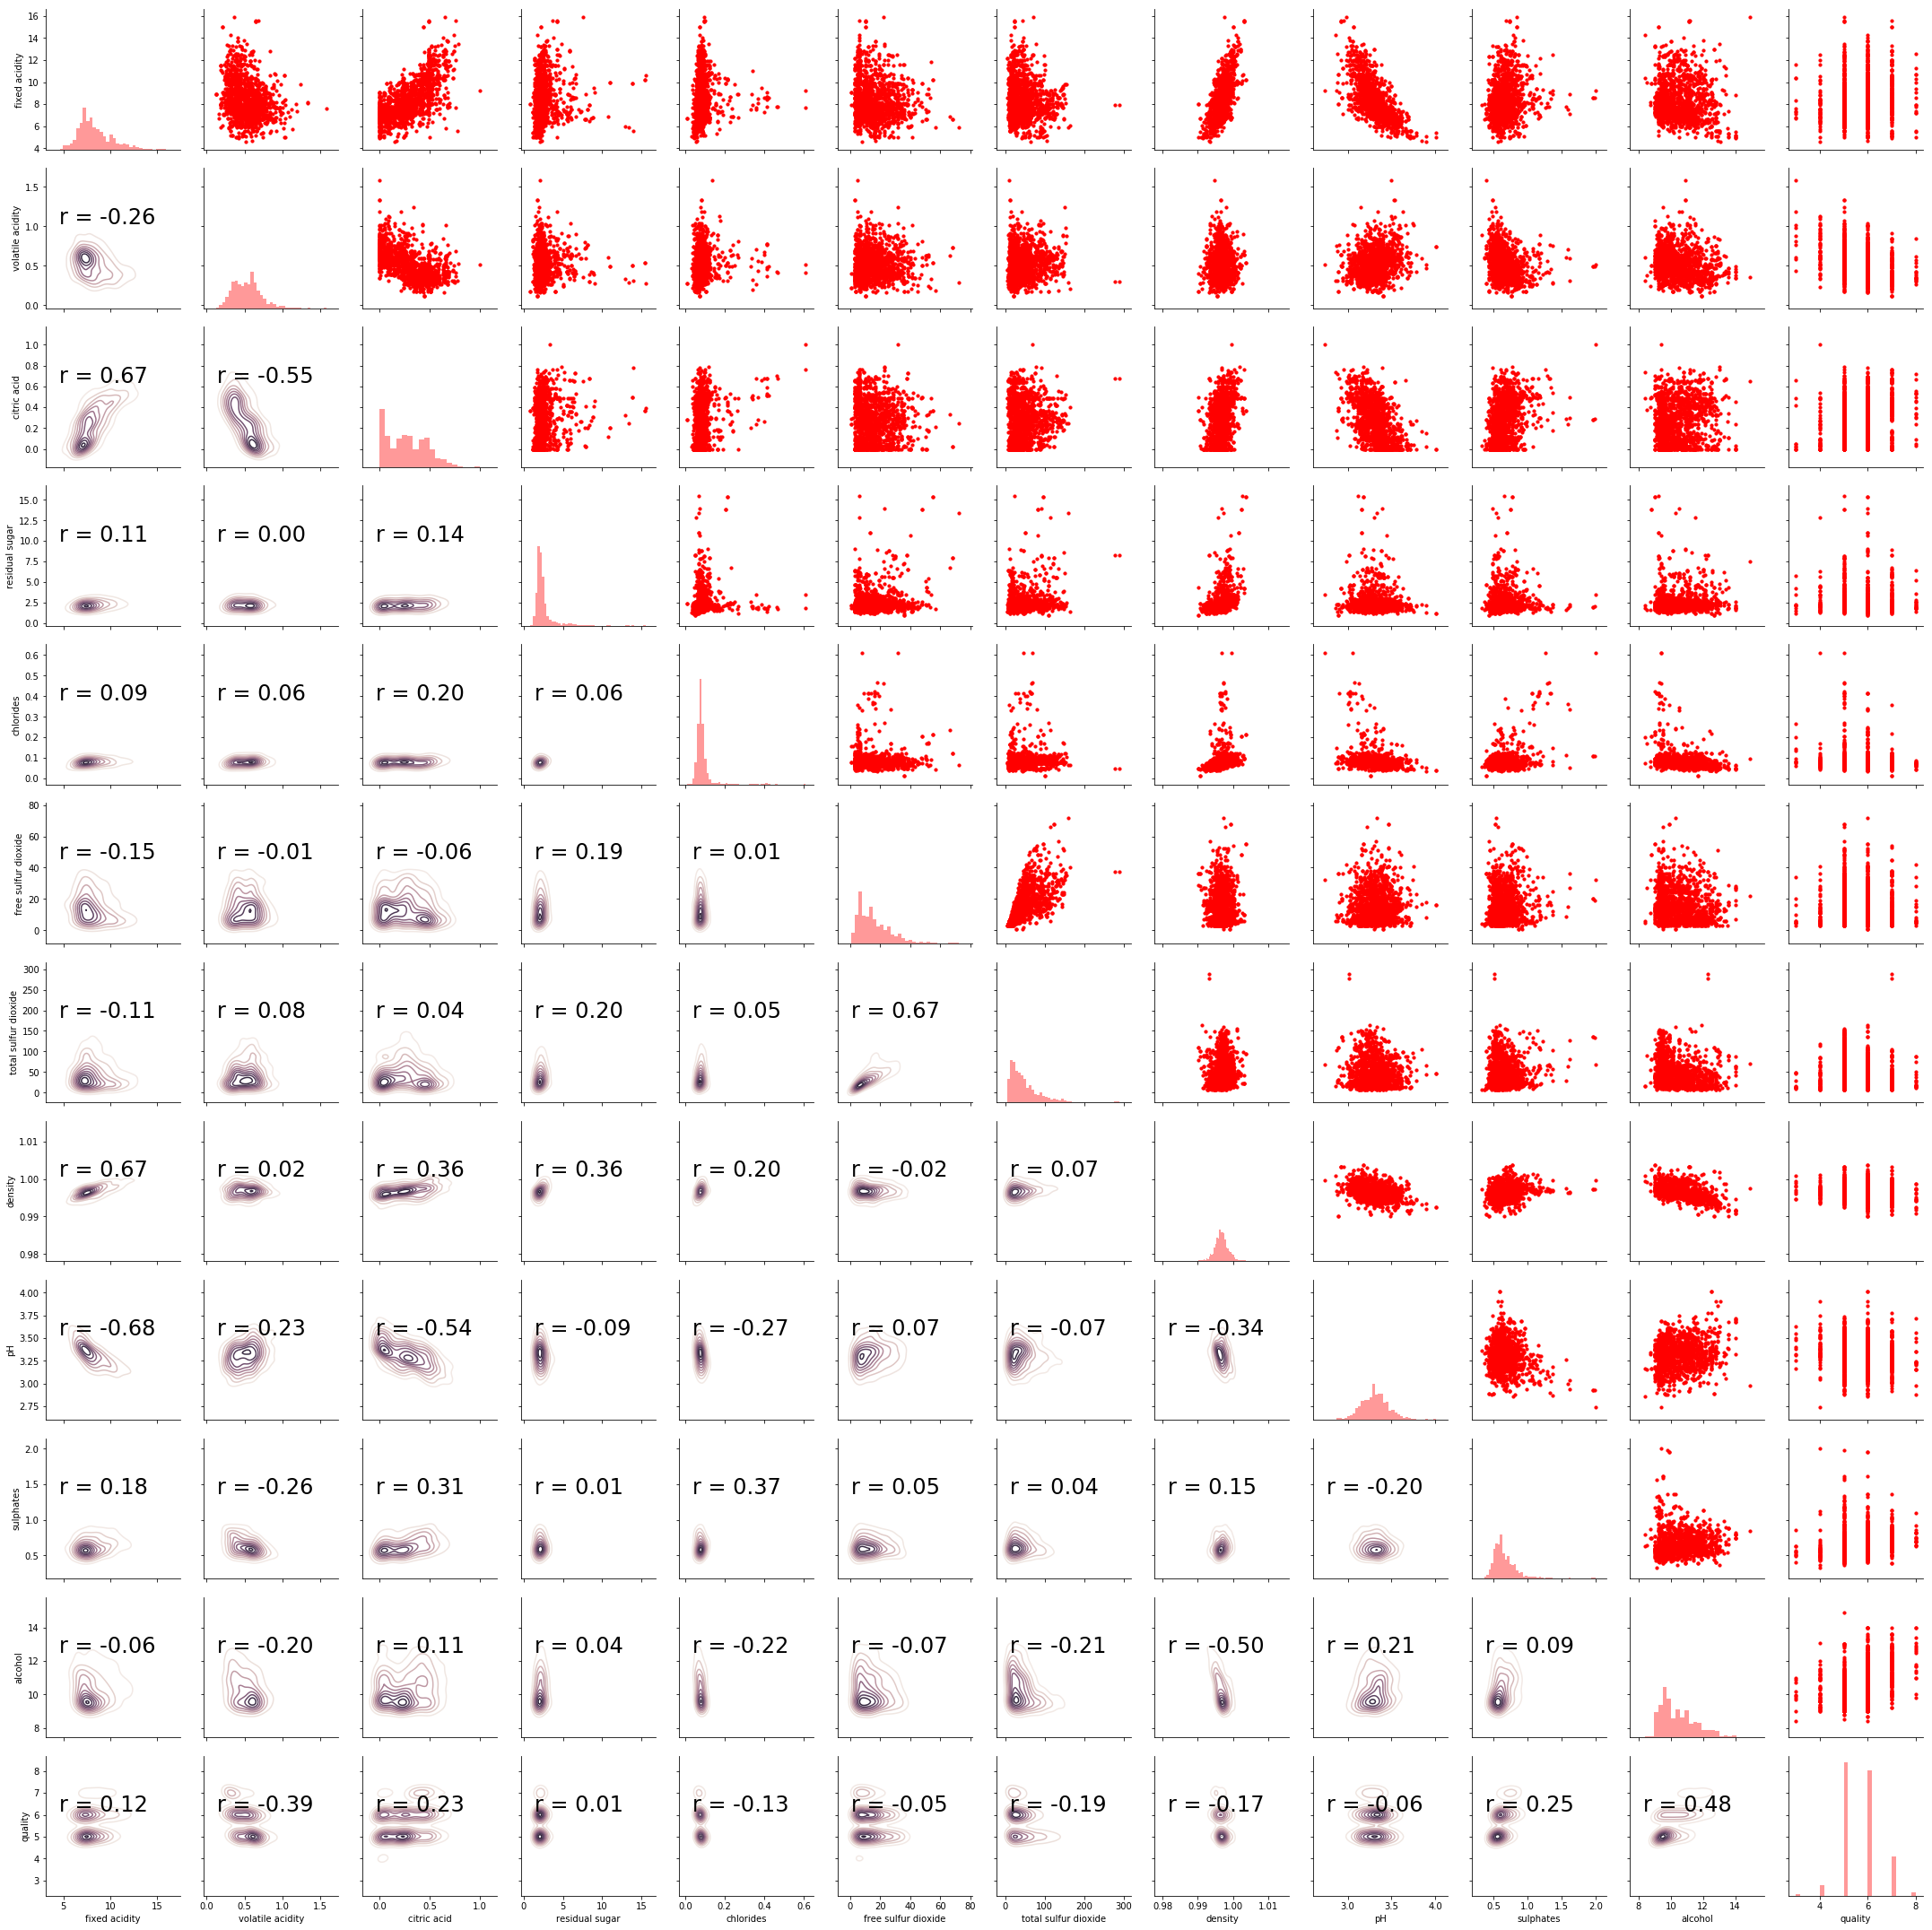

In [10]:
import seaborn as sns
from scipy import stats

# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(df)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

In [11]:
def train_test_split(X,y,t):
    size = X.shape[0]
    split_idx = int(size*(1-t))    
    return X[:split_idx], X[split_idx:],y[:split_idx], y[split_idx:]

def partition(X, y, t):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 0.2)   
    return X_train, X_test, y_train, y_test

# Part C: Model Evaluation

In [12]:
print("Solution 11")

def partition_data(data,folds):
    
    split_idx=int(data.shape[0]/folds)
    idx=[]
    indexes= np.arange(0,data.shape[0])
    
    for f in range(folds):
        
        test = indexes[:split_idx]
        train = indexes[split_idx:]
        i=np.arange(0,split_idx)
        indexes=np.delete(indexes,i)        
        indexes=np.append(indexes,test)
        idx.append((train,test))
        
    return np.asarray(idx)

def kFold(folds, X, y, model, error_function, **model_args):
    split_folds=partition_data(X,folds)
    test_error = []
    true_label = []
    pred_label = []
    train_error = []
    for train_index, test_index in split_folds:
        X_t, X_te = X[train_index], X[test_index]
        y_t, y_te = y[train_index], y[test_index]
        
        learning_rate_init, epoch_init , tol_init, regularizer_init, lambd_init , degree_init = 0.001, 1000, None,None,0.0,1 
        
        
        for key, value in model_args.items(): 
            
            if key=='learning_rate':
                learning_rate_init=value
            if key=='epochs':
                epoch_init=value
            if key=='tol':
                tol_init=value
            if key=="regularizer":
                regularizer_init=value
            if key=="lambd":
                lambd_init=value
                
            if key == "degree":
                degree_init = value
            
        
        model.fit(X_t, y_t, learning_rate = learning_rate_init, epochs= epoch_init, tol = tol_init,
                  regularizer = regularizer_init,lambd = lambd_init, degree = degree_init, error = error_function)
        
        
        
        y_test_pred=model.predict( X_te)
        y_train_pred = model.predict( X_t)
            
     
        

        true_label.append(y_te)
        pred_label.append(y_test_pred)
        
        if error_function == "mse":
            
            avg_test_error = mse(y_test_pred, y_te)
            avg_train_error = mse(y_train_pred, y_t)
            
        elif error_function == "rmse":
            avg_test_error = np.sqrt(mse(y_test_pred, y_te))
            avg_train_error = np.sqrt(mse(y_train_pred, y_t))
        
        test_error.append(avg_test_error)
        train_error.append(avg_train_error)
    
    
    return np.array(pred_label), np.array(true_label), np.mean(np.array(train_error)), np.mean(np.array(test_error))  

Solution 11


In [13]:
X = np.array(df.drop( "quality", axis = 1))
y = np.array(df['quality'])

print(X.shape)
print(y.shape)

scaler = MinMaxScaler().fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = partition(X, y, 0.2)
print(X_train.shape)
print(X_test.shape)

(1599, 11)
(1599,)
(1279, 11)
(320, 11)


In [14]:
print("Solution 12")


lambds= [1.0, 0,0.1,0.01, 0.001, 0.0001]
learning_rates = [1.0, 0.1, 0.01, 0.001, 0.0001]
regularizers = ["l1", "l2"]

lowest_error = sys.maxsize
best_lambd, best_learning_rate, best_regularizer = 1.0, 1.0, "l1"
best_y_pred, best_y_true = [],[]

for l in lambds:
    for lr in learning_rates:
        for r in regularizers:
            
            linear_regression = Linear_Regression()
            y_pred, y_true, train_error, test_error = kFold(3, X_train, y_train, linear_regression, "mse", lambd = l, learning_rate= lr, regularizer= r)
            
            
            print( "MSE: ", test_error, "lambd: " , l, "learning_rate: ", lr, "regularizer: ", r)
            if lowest_error > test_error:
                
                best_lambd, best_learning_rate, best_regularizer, lowest_error = l, lr, r, test_error              
                best_y_pred, best_y_true = y_pred, y_true
                best_model = linear_regression
                
print("best_lambd, best_learning_rate, best_regularizer, lowest_error, best_y_pred, best_y_true :" ,
      best_lambd, best_learning_rate, best_regularizer, lowest_error)

Solution 12
MSE:  1.965110331638464e+17 lambd:  1.0 learning_rate:  1.0 regularizer:  l1


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in square
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in square


MSE:  nan lambd:  1.0 learning_rate:  1.0 regularizer:  l2
MSE:  0.48500000000000004 lambd:  1.0 learning_rate:  0.1 regularizer:  l1
MSE:  0.46976666666666667 lambd:  1.0 learning_rate:  0.1 regularizer:  l2
MSE:  0.7065666666666667 lambd:  1.0 learning_rate:  0.01 regularizer:  l1
MSE:  0.7025 lambd:  1.0 learning_rate:  0.01 regularizer:  l2
MSE:  1.4399 lambd:  1.0 learning_rate:  0.001 regularizer:  l1
MSE:  1.4488666666666667 lambd:  1.0 learning_rate:  0.001 regularizer:  l2
MSE:  22.327633333333335 lambd:  1.0 learning_rate:  0.0001 regularizer:  l1
MSE:  22.32336666666667 lambd:  1.0 learning_rate:  0.0001 regularizer:  l2
MSE:  1.8045127017315933e+17 lambd:  0 learning_rate:  1.0 regularizer:  l1
MSE:  1.8045127017315933e+17 lambd:  0 learning_rate:  1.0 regularizer:  l2
MSE:  0.48856666666666665 lambd:  0 learning_rate:  0.1 regularizer:  l1
MSE:  0.48856666666666665 lambd:  0 learning_rate:  0.1 regularizer:  l2
MSE:  0.7071999999999999 lambd:  0 learning_rate:  0.01 regula

In [15]:
print("Solution 13")

best_y_test_pred = best_model.predict(X_test)
print("Mean squared error on test data: ", mse(best_y_test_pred, y_test))

Solution 13
Mean squared error on test data:  0.4864


Solution 14


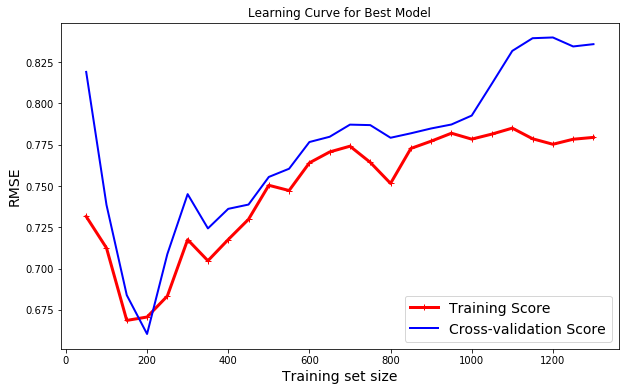

In [16]:
print("Solution 14")
#Plot the learning curve

train_rmse, test_rmse, train_size = learning_curve(best_model, X_train, y_train, 3, train_size=50, learning_rate=best_learning_rate,
                  epochs=1000, tol=None, regularizer=best_regularizer, lambd=best_lambd)


plt.figure(figsize=(10, 6))
plt.plot(train_size, train_rmse, "r-+", linewidth=3, label="Training Score")
plt.plot(train_size, test_rmse, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14) 
plt.xlabel("Training set size", fontsize=14) 
plt.ylabel("RMSE", fontsize=14) 
plt.title("Learning Curve for Best Model")
plt.show()

In [17]:
print("Solution 15")
#best model parameters

lambds= [1.0, 0,0.1,0.01, 0.001, 0.0001]
learning_rates = [1.0, 0.1, 0.01, 0.001, 0.0001]
regularizers = ["l1", "l2"]

lowest_error = sys.maxsize
best_lambd, best_learning_rate, best_regularizer = 1.0, 1.0, "l1"
best_y_pred, best_y_true = [],[]

X_train_Deg = polynomialFeatures(X_train, 3)
for l in lambds:
    for lr in learning_rates:
        for r in regularizers:
            
            linear_regression = Linear_Regression()
            y_pred, y_true, train_error, test_error = kFold(3, X_train_Deg, y_train, linear_regression, "mse",
                                                            lambd = l, learning_rate= lr, regularizer= r, degree = 3)
            
            
            print("MSE: ", test_error, "lambd: " , l, "learning_rate: ", lr, "regularizer: ", r)
            
            if lowest_error > test_error:
                
                best_lambd, best_learning_rate, best_regularizer, lowest_error = l, lr, r, test_error              
                best_y_pred, best_y_true = y_pred, y_true
                best_model = linear_regression
                
print("best_lambd, best_learning_rate, best_regularizer, lowest_error, best_y_pred, best_y_true :" ,
      best_lambd, best_learning_rate, best_regularizer, lowest_error)

Solution 15


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: RuntimeWarning: overflow encountered in multiply
  return getattr(obj, method)(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:75: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in square
  This is separate from the ipykernel package so we can avoid doing imports until


MSE:  nan lambd:  1.0 learning_rate:  1.0 regularizer:  l1


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in square


MSE:  nan lambd:  1.0 learning_rate:  1.0 regularizer:  l2
MSE:  0.45503333333333335 lambd:  1.0 learning_rate:  0.1 regularizer:  l1
MSE:  nan lambd:  1.0 learning_rate:  0.1 regularizer:  l2
MSE:  0.7610666666666667 lambd:  1.0 learning_rate:  0.01 regularizer:  l1
MSE:  0.6847666666666666 lambd:  1.0 learning_rate:  0.01 regularizer:  l2
MSE:  1.4449666666666667 lambd:  1.0 learning_rate:  0.001 regularizer:  l1
MSE:  1.4516333333333336 lambd:  1.0 learning_rate:  0.001 regularizer:  l2
MSE:  19.858433333333334 lambd:  1.0 learning_rate:  0.0001 regularizer:  l1
MSE:  19.8491 lambd:  1.0 learning_rate:  0.0001 regularizer:  l2
MSE:  nan lambd:  0 learning_rate:  1.0 regularizer:  l1


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars


MSE:  nan lambd:  0 learning_rate:  1.0 regularizer:  l2
MSE:  0.44493333333333335 lambd:  0 learning_rate:  0.1 regularizer:  l1
MSE:  0.44493333333333335 lambd:  0 learning_rate:  0.1 regularizer:  l2
MSE:  0.7828666666666667 lambd:  0 learning_rate:  0.01 regularizer:  l1
MSE:  0.7828666666666667 lambd:  0 learning_rate:  0.01 regularizer:  l2
MSE:  1.4447666666666665 lambd:  0 learning_rate:  0.001 regularizer:  l1
MSE:  1.4447666666666665 lambd:  0 learning_rate:  0.001 regularizer:  l2
MSE:  19.846933333333332 lambd:  0 learning_rate:  0.0001 regularizer:  l1
MSE:  19.846933333333332 lambd:  0 learning_rate:  0.0001 regularizer:  l2
MSE:  nan lambd:  0.1 learning_rate:  1.0 regularizer:  l1
MSE:  nan lambd:  0.1 learning_rate:  1.0 regularizer:  l2
MSE:  0.44616666666666666 lambd:  0.1 learning_rate:  0.1 regularizer:  l1
MSE:  0.43966666666666665 lambd:  0.1 learning_rate:  0.1 regularizer:  l2
MSE:  0.7810333333333334 lambd:  0.1 learning_rate:  0.01 regularizer:  l1
MSE:  0.76

Mean squared error on test data:  0.4688
Solution 14


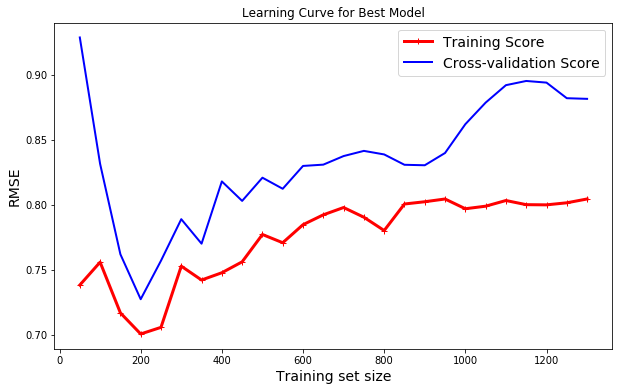

In [18]:
X_test_deg = polynomialFeatures(X_test, 3)
X_train_deg = polynomialFeatures(X_train, 3)
best_y_test_pred = best_model.predict(X_test_deg)
print("Mean squared error on test data: ", mse(best_y_test_pred, y_test))

print("Solution 14")
#Plot the learning curve

train_rmse, test_rmse, train_size = learning_curve(best_model, X_train_deg, y_train, 3, train_size=50, learning_rate=0.00001,
                  epochs=1000, tol=None, regularizer=best_regularizer, lambd=best_lambd)


plt.figure(figsize=(10, 6))
plt.plot(train_size, train_rmse, "r-+", linewidth=3, label="Training Score")
plt.plot(train_size, test_rmse, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14) 
plt.xlabel("Training set size", fontsize=14) 
plt.ylabel("RMSE", fontsize=14) 
plt.title("Learning Curve for Best Model")
plt.show()

Solution 16:


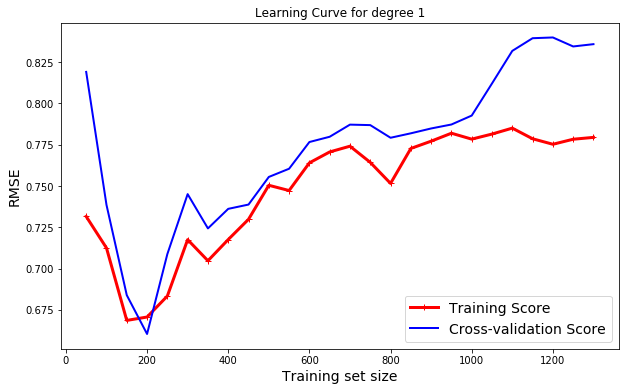

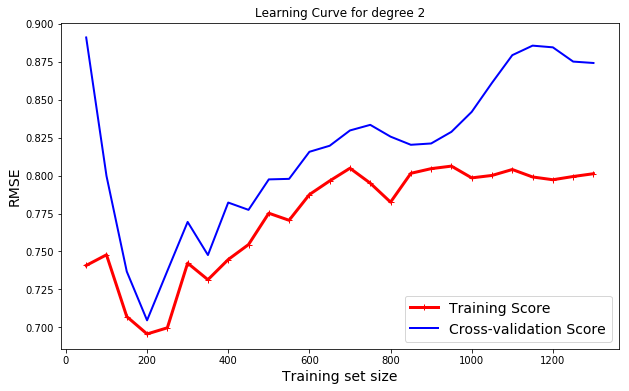

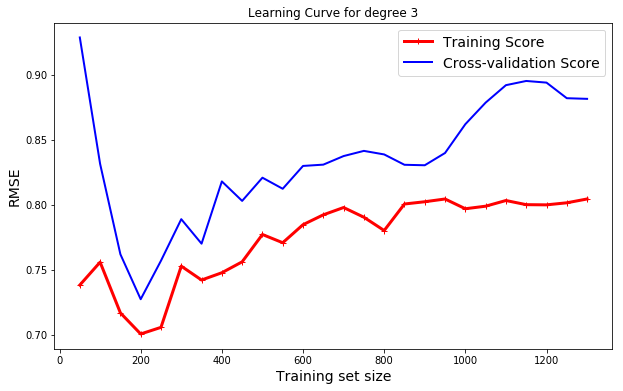

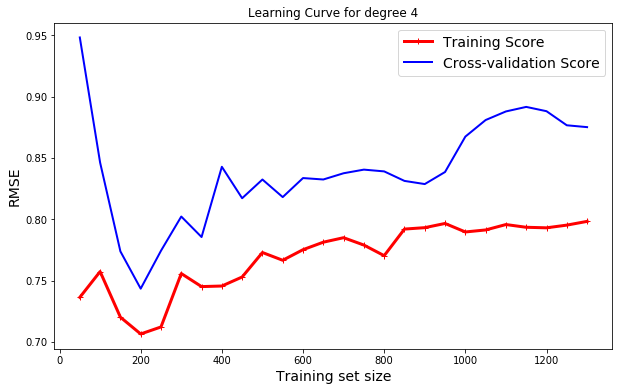

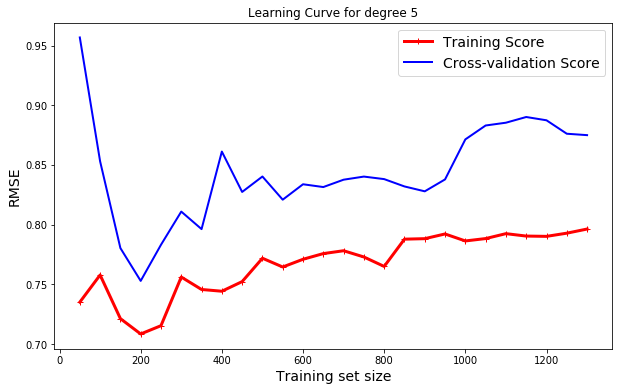

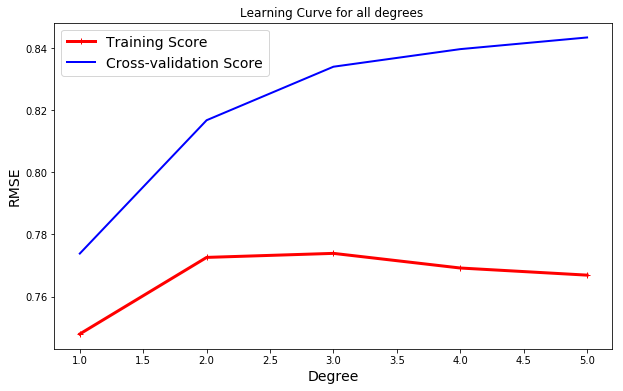

In [19]:
print("Solution 16:")
poly_model = Linear_Regression()
plot_polynomial_model_complexity(poly_model, X_train, y_train, 3, 5, learning_rate=0.001,
                                 epochs=1000, tol=None, regularizer="l2", lambd=0.0)

In [20]:
class Linear_Regression_SGD:
    
    def __init__(self):
        pass
    
    def fit(self, X, y, learning_rate=0.01, epochs=1000, tol=None, regularizer=None,lambd=0.0,**kwargs):
        self.degree = None
        self.error_function = None
        for key, value in kwargs.items():
            if key == "degree":
                self.degree = value
                
            if key == "error":
                self.error_function = value
        
       
        self.X = X
            
        self.y = y
        self.learning_rate =learning_rate
        self.epochs = epochs
        self.tol = tol
        self.regularizer =regularizer
        self.lambd = lambd
        
        theta_hat = np.zeros(shape = (self.X.shape[1]+1,))
               
        m = self.X.shape[0]
        X_bias=np.c_[np.ones((self.X.shape[0],1)),self.X]
        
        
        y_hat = np.dot(X_bias, theta_hat)
        prev_theta_hat = theta_hat # to save a copy of the previous theta values
        prev_error, regularized_theta = regularizer_error(regularizer, y_hat, self.y , theta_hat,self.error_function)
        
        
        for epoch in range(self.epochs): 
            # shuffle the data
            for row in range(X_bias.shape[0]):
                
                if regularizer == "l1":             
                    regularized_constant = (self.learning_rate*self.lambd*(-1 if regularized_theta < 0 else 1)/ m)   
                               
                elif regularizer == "l2": 
                    regularized_constant = (self.learning_rate*self.lambd* regularized_theta)/ m
                
                else:
                    regularized_constant = 0
           
                theta_hat = theta_hat - ((self.learning_rate/m)*np.dot(X_bias[row,:].T , (y_hat[row] - self.y[row]))) - regularized_constant
                y_hat = np.dot(X_bias, theta_hat)
                current_error, regularized_theta = regularizer_error(self.regularizer, y_hat[row], self.y[row], theta_hat,self.error_function)
            
                if tol:
                    if current_error - tol > prev_error:
                        theta_hat = prev_theta_hat  # if current error is greater save prev theta_hat                        
                        break
                
        
                prev_theta_hat = theta_hat  # save copy to compute contigous errors.
                prev_error = current_error
                                     
                                     
        self.theta = theta_hat
        
        
        
        
    def predict(self, X_test):
        X_test_bias=np.c_[np.ones((X_test.shape[0],1)),X_test]
        y_pred = np.dot(X_test_bias, self.theta)
        
        return y_pred
        
 

Stochastic MSE:  0.5925


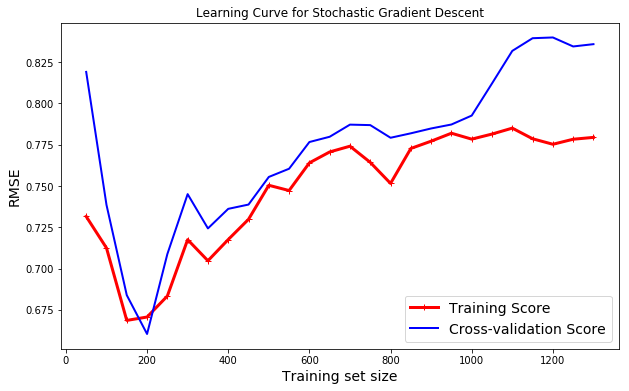

In [21]:
#model evaluation

sgd_gradient_descent = Linear_Regression_SGD()
sgd_gradient_descent.fit(X_train, y_train)
y_pred = sgd_gradient_descent.predict(X_test)

mse_sgd = mse(y_pred, y_test)
print("Stochastic MSE: ",mse_sgd)


train_sgd_rmse, test_sgd_rmse, train_sgd_size = learning_curve(sgd_gradient_descent, X_train, y_train, 3, train_size=50, learning_rate=0.01,
                  epochs=1000, tol=None, regularizer=None, lambd=0.0)


plt.figure(figsize=(10, 6))
plt.plot(train_sgd_size, train_sgd_rmse, "r-+", linewidth=3, label="Training Score")
plt.plot(train_sgd_size, test_sgd_rmse, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14) 
plt.xlabel("Training set size", fontsize=14) 
plt.ylabel("RMSE", fontsize=14) 
plt.title("Learning Curve for Stochastic Gradient Descent")
plt.show()